# Disciplines

In [20]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass

In [21]:
from gemseo.disciplines.auto_py import AutoPyDiscipline
discipline_aerodynamic = AutoPyDiscipline(aerodynamic)
discipline_approach = AutoPyDiscipline(approach)
discipline_battery = AutoPyDiscipline(battery)
discipline_climb = AutoPyDiscipline(climb)
discipline_engine = AutoPyDiscipline(engine)
discipline_fuel_tank = AutoPyDiscipline(fuel_tank)
discipline_geometry = AutoPyDiscipline(geometry)
discipline_mass = AutoPyDiscipline(mass)
discipline_mission = AutoPyDiscipline(mission)
discipline_operating_cost = AutoPyDiscipline(operating_cost)
discipline_take_off = AutoPyDiscipline(take_off)
discipline_total_mass = AutoPyDiscipline(total_mass)


In [22]:
disciplines = [discipline_aerodynamic,discipline_approach,discipline_battery,discipline_climb,discipline_engine,
               discipline_fuel_tank,discipline_geometry,discipline_mass,discipline_mission,discipline_operating_cost,
               discipline_take_off,discipline_total_mass]

# Design space

In [23]:
from gemseo import configure_logger
configure_logger()

<RootLogger root (INFO)>

In [24]:
from gemseo_oad_training.unit import convert_from
from gemseo.algos.parameter_space import ParameterSpace
from utils import update_default_inputs

x_def={'slst':100000,'n_pax':20.0,'area':111.58,'ar':8.8912,'fuel_type':'liquid_h2','engine_type':'turbofan','design_range':5500000}
update_default_inputs(disciplines,x_def)

uncertain_space = ParameterSpace()
uncertain_space.add_random_variable("gi","OTTriangularDistribution", minimum=0.35, mode=0.4, maximum=0.405)
uncertain_space.add_random_variable("vi","OTTriangularDistribution", minimum=0.755, mode=0.800, maximum=0.805)
uncertain_space.add_random_variable("aef","OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("cef","OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("sef","OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)

In [25]:
from gemseo import sample_disciplines
from gemseo.disciplines.surrogate import SurrogateDiscipline

training_dataset = sample_disciplines(disciplines, uncertain_space, ["tofl", "vapp","vz","span","length","fm","mtom"], algo_name="OT_MONTE_CARLO", n_samples=100)

    INFO - 16:48:10: *** Start Sampling execution ***
    INFO - 16:48:10: Sampling
    INFO - 16:48:10:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 16:48:10:    MDO formulation: MDF
    INFO - 16:48:10: Running the algorithm OT_MONTE_CARLO:
    INFO - 16:48:10:      1%|          | 1/100 [00:00<00:05, 17.29 it/sec]

    INFO - 16:48:12:    100%|██████████| 100/100 [00:01<00:00, 50.06 it/sec]
    INFO - 16:48:12: *** End Sampling execution (time: 0:00:02.018669) ***


In [26]:
import matplotlib.pyplot as plt
import pprint

In [27]:
surrogate_discipline = SurrogateDiscipline("RBFRegressor", training_dataset)

In [28]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")
rmse.compute_learning_measure(as_dict=True)

{'fm': array([5.84846269e-17]),
 'length': array([3.55271368e-15]),
 'mtom': array([4.17971943e-12]),
 'span': array([0.]),
 'tofl': array([7.45494449e-14]),
 'vapp': array([0.]),
 'vz': array([1.54859199e-15])}

In [29]:
rmse.compute_cross_validation_measure(as_dict=True)

{'fm': array([0.00124402]),
 'length': array([3.55271368e-15]),
 'mtom': array([35.49485727]),
 'span': array([0.]),
 'tofl': array([1.39113936]),
 'vapp': array([0.02548233]),
 'vz': array([0.01797988])}

In [30]:
from gemseo.uncertainty.statistics.empirical_statistics import EmpiricalStatistics

In [31]:
statistics = EmpiricalStatistics(training_dataset)
mean = statistics.compute_mean()
mean

{'aef': array([1.00852155]),
 'cef': array([1.00566636]),
 'fm': array([0.21505233]),
 'gi': array([0.38656094]),
 'length': array([18.08333333]),
 'mtom': array([42770.76663658]),
 'sef': array([1.00613398]),
 'span': array([31.497303]),
 'tofl': array([907.21519506]),
 'vapp': array([55.62187432]),
 'vi': array([0.78770926]),
 'vz': array([10.9857781])}

In [32]:
variance = statistics.compute_variance()
variance

{'aef': array([6.81645596e-05]),
 'cef': array([6.36776767e-05]),
 'fm': array([0.00047429]),
 'gi': array([0.00015218]),
 'length': array([0.]),
 'mtom': array([285180.20449285]),
 'sef': array([6.78384882e-05]),
 'span': array([5.04870979e-29]),
 'tofl': array([411.920635]),
 'vapp': array([0.14680487]),
 'vi': array([0.00013086]),
 'vz': array([0.08897203])}

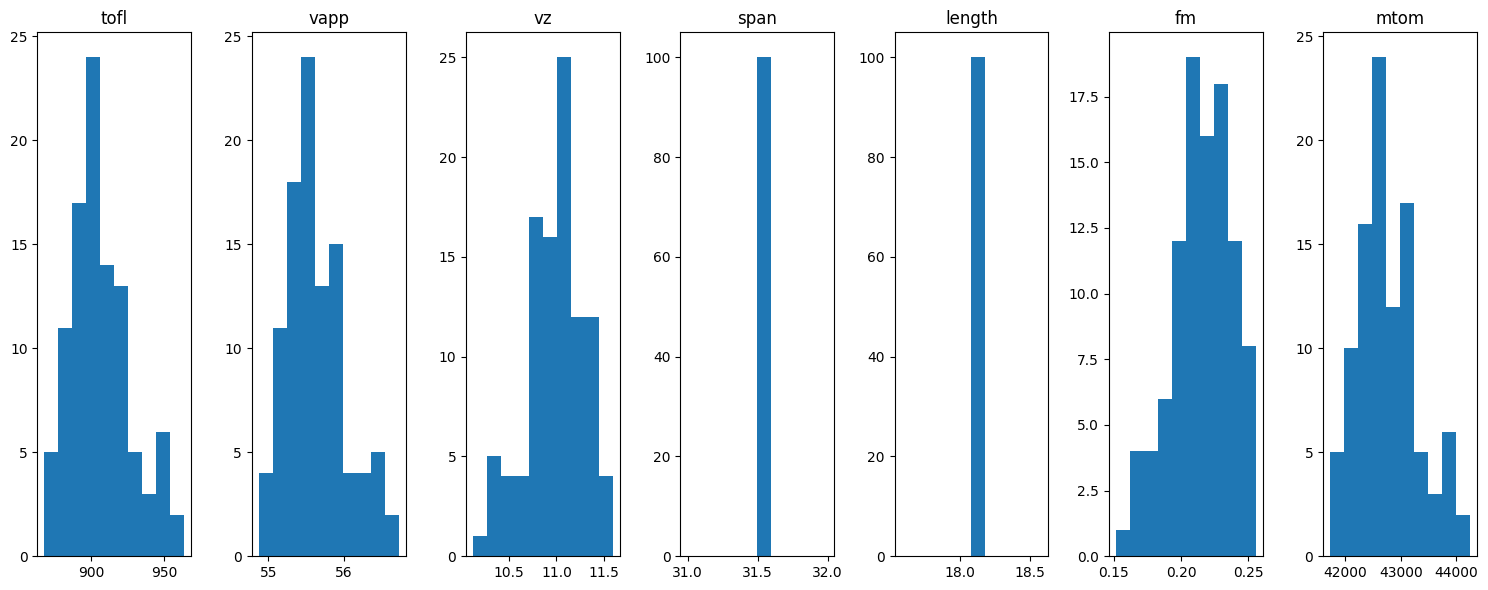

In [33]:
fig, axes = plt.subplots(1, 7,figsize=(15,6))
for ax, name in zip(axes, ["tofl", "vapp","vz","span","length","fm","mtom"]):
    ax.hist(training_dataset.get_view(variable_names=name))
    ax.set_title(name)
plt.tight_layout()
plt.show()

In [34]:
from gemseo.uncertainty.sensitivity.sobol_analysis import SobolAnalysis


In [35]:
sobol = SobolAnalysis()
sobol.compute_samples([surrogate_discipline], uncertain_space, 100)

 WARNING - 16:48:15: No coupling in MDA, switching chain_linearize to True.
    INFO - 16:48:15: *** Start SobolAnalysisSamplingPhase execution ***
    INFO - 16:48:15: SobolAnalysisSamplingPhase
    INFO - 16:48:15:    Disciplines: RBF_Sampling
    INFO - 16:48:15:    MDO formulation: MDF
    INFO - 16:48:15: Running the algorithm OT_SOBOL_INDICES:
    INFO - 16:48:16:    100%|██████████| 96/96 [00:01<00:00, 58.24 it/sec]
    INFO - 16:48:16: *** End SobolAnalysisSamplingPhase execution (time: 0:00:01.689071) ***


GROUP        inputs                                           outputs  \
VARIABLE         gi        vi       aef       cef       sef        fm   
COMPONENT         0         0         0         0         0         0   
0          0.394131  0.779313  1.028623  1.018127  1.006415  0.177245   
1          0.366964  0.764723  1.014139  0.994315  0.994671  0.191166   
2          0.394951  0.799486  1.009626  1.024286  1.003858  0.210644   
3          0.375284  0.796036  1.013230  0.997688  1.001509  0.234504   
4          0.375179  0.799914  1.017345  0.996241  1.006883  0.239611   
..              ...       ...       ...       ...       ...       ...   
91         0.365560  0.778220  1.020575  1.009792  1.001509  0.189386   
92         0.398343  0.776086  1.007875  1.003573  1.006883  0.199591   
93         0.387046  0.772072  1.007799  1.001951  1.003720  0.195452   
94         0.400720  0.781155  1.002871  0.993853  1.014974  0.222071   
95         0.394662  0.778199  0.997953  1.006463  1.010079  0.205358   

GROUP                                                                 \
VARIABLE      length          mtom       span        tofl       vapp   
COMPONENT          0             0          0           0          0   
0          18.083333  42506.341131  31.497303  897.138365  55.362529   
1          18.083333  43012.518449  31.497303  916.395108  55.820725   
2          18.083333  42628.829027  31.497303  901.779578  55.462126   
3          18.083333  43163.140345  31.497303  922.021945  55.922692   
4          18.083333  43332.914952  31.497303  928.539065  56.041895   
..               ...           ...        ...         ...        ...   
91         18.083333  43404.334156  31.497303  931.263081  56.046608   
92         18.083333  42210.080547  31.497303  886.008920  55.225769   
93         18.083333  42490.077843  31.497303  896.488931  55.433995   
94         18.083333  42319.174362  31.497303  890.092851  55.341890   
95         18.083333  42419.658305  31.497303  893.852893  55.384070   

GROUP                 
VARIABLE          vz  
COMPONENT          0  
0          11.009050  
1          10.820768  
2          11.057051  
3          10.738719  
4          10.622428  
..               ...  
91         10.566636  
92         11.299570  
93         11.142278  
94         11.267092  
95         11.243360  

[96 rows x 12 columns]

In [36]:
sobol.compute_indices(output_names=["tofl", "vapp","vz","fm","mtom"])

SobolAnalysis.SensitivityIndices(first={'tofl': [{'gi': array([1.75557369]), 'vi': array([0.1605344]), 'aef': array([0.34941117]), 'cef': array([0.28905501]), 'sef': array([0.49874107])}], 'vapp': [{'gi': array([1.50526817]), 'vi': array([0.10469313]), 'aef': array([0.19780095]), 'cef': array([0.1825469]), 'sef': array([0.41031337])}], 'vz': [{'gi': array([1.81505198]), 'vi': array([0.11561783]), 'aef': array([0.72597781]), 'cef': array([0.30672521]), 'sef': array([0.47261314])}], 'fm': [{'gi': array([-0.29933453]), 'vi': array([0.32219769]), 'aef': array([-0.18930155]), 'cef': array([-0.07478566]), 'sef': array([-0.31066865])}], 'mtom': [{'gi': array([1.75918926]), 'vi': array([0.16246763]), 'aef': array([0.3498282]), 'cef': array([0.28963997]), 'sef': array([0.50301467])}]}, second={'tofl': [{'gi': {'gi': array([[0.]]), 'vi': array([[-0.57165458]]), 'aef': array([[-0.95552981]]), 'cef': array([[-0.86213979]]), 'sef': array([[-0.21734876]])}, 'vi': {'gi': array([[-0.57165458]]), 'vi':

In [37]:
pprint.pprint(sobol.indices.first)
pprint.pprint(sobol.indices.total)

{'fm': [{'aef': array([-0.18930155]),
         'cef': array([-0.07478566]),
         'gi': array([-0.29933453]),
         'sef': array([-0.31066865]),
         'vi': array([0.32219769])}],
 'mtom': [{'aef': array([0.3498282]),
           'cef': array([0.28963997]),
           'gi': array([1.75918926]),
           'sef': array([0.50301467]),
           'vi': array([0.16246763])}],
 'tofl': [{'aef': array([0.34941117]),
           'cef': array([0.28905501]),
           'gi': array([1.75557369]),
           'sef': array([0.49874107]),
           'vi': array([0.1605344])}],
 'vapp': [{'aef': array([0.19780095]),
           'cef': array([0.1825469]),
           'gi': array([1.50526817]),
           'sef': array([0.41031337]),
           'vi': array([0.10469313])}],
 'vz': [{'aef': array([0.72597781]),
         'cef': array([0.30672521]),
         'gi': array([1.81505198]),
         'sef': array([0.47261314]),
         'vi': array([0.11561783])}]}
{'fm': [{'aef': array([0.17052966]),
       

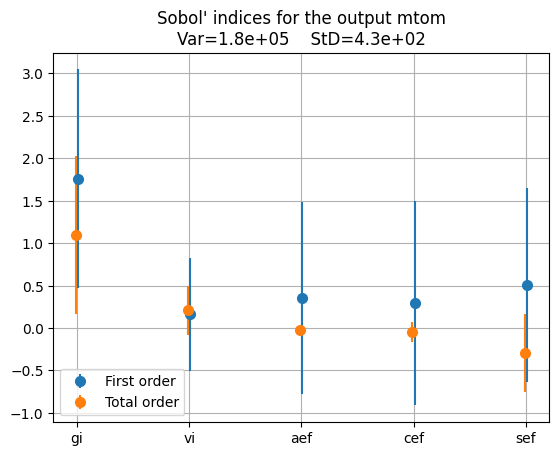

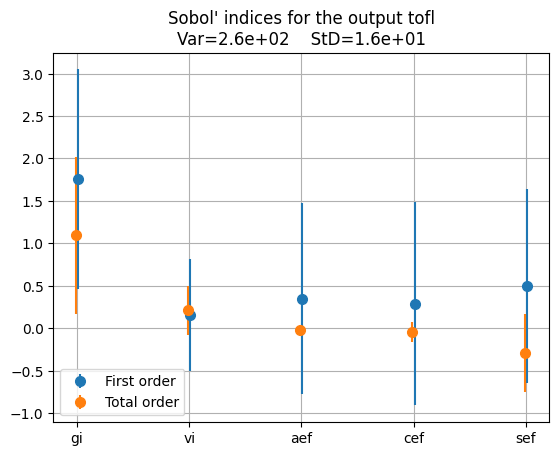

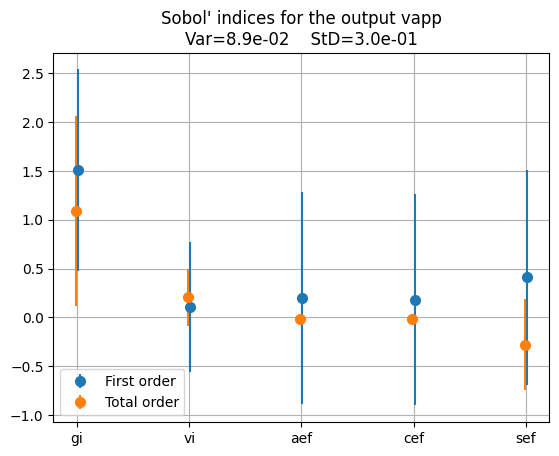

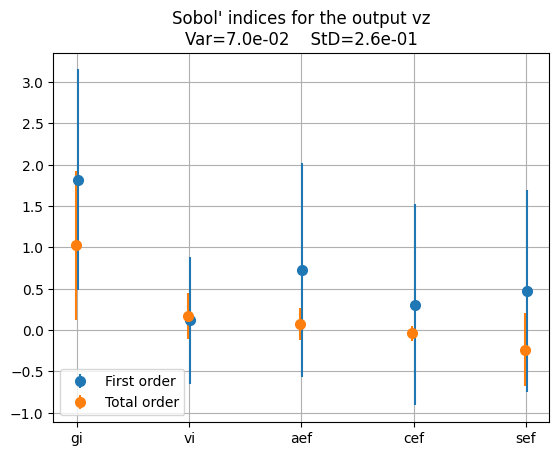

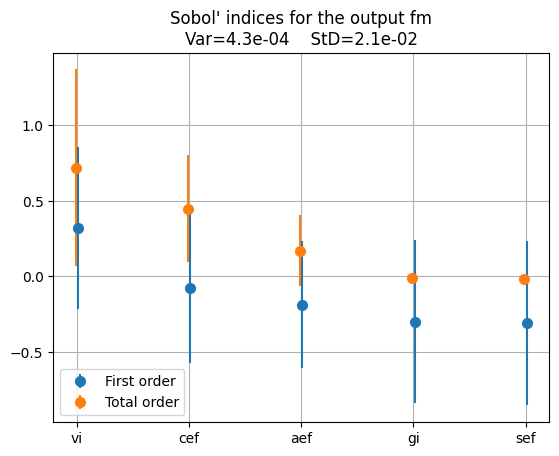

In [38]:
plt.show(sobol.plot("mtom", save=False, show=True))
plt.show(sobol.plot("tofl", save=False, show=True))
plt.show(sobol.plot("vapp", save=False, show=True))
plt.show(sobol.plot("vz", save=False, show=True))
plt.show(sobol.plot("fm", save=False, show=True))